In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, Reshape, Input
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [4]:
y_train[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [5]:
# convert from numpy to tensor
x_dataset = tf.data.Dataset.from_tensor_slices(x_train)
y_dataset = tf.data.Dataset.from_tensor_slices(y_train)

def process_x(x):
    # transformation the type of data -> normalize
    img = tf.cast(x, tf.float32) / 255
    return img

def process_y(y):
    y = tf.one_hot(y, 10)
    return y

x_dataset = x_dataset.map(process_x)
y_dataset = y_dataset.map(process_y)
dataset = tf.data.Dataset.zip((x_dataset, y_dataset))
dataset = dataset.shuffle(1000)  # shuffle first 1000
dataset = dataset.batch(64) # batch_size 64
AUTOTUNE = tf.data.AUTOTUNE # auto select optimal size buffer
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE) # preloading data during training

In [6]:
# print first batch
for element in dataset.take(1):
    print(element)

(<tf.Tensor: shape=(64, 28, 28), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0.,

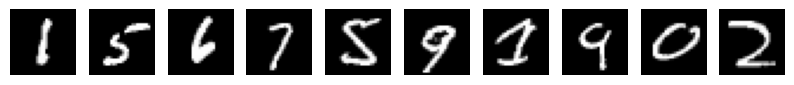

In [7]:
def imshow():
    n = 10
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(n):
            img = images[i]
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(img, cmap='gist_gray')
            plt.axis('off')
            ax.get_yaxis().set_visible(False)
    plt.show()
imshow()

In [8]:
inputs = Input(shape=(28, 28))
x = Flatten()(inputs) # flatten to one-dimensional vector 28*28=784
x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(10, activation='sigmoid')(x) # sigmoid [0:1]
outputs = x

simple_nn = keras.Model(inputs, outputs)

In [9]:
class Model(tf.keras.Model):
    def __init__(self, nn):
        super(Model, self).__init__()
        self.nn = nn

    def get_loss(self, y, preds):
        loss = tf.keras.losses.CategoricalCrossentropy()(y, preds)
        return loss

    @tf.function
    def training_step(self, x, y):
        with tf.GradientTape() as tape:
            preds = self.nn(x)
            loss = self.get_loss(y, preds)

        gradients = tape.gradient(loss, self.nn.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.nn.trainable_variables))
        return tf.reduce_mean(loss)

In [10]:
model = Model(simple_nn)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

In [11]:
for x, y in dataset.take(1):
    print(model.training_step(x, y))

tf.Tensor(2.345133, shape=(), dtype=float32)


100


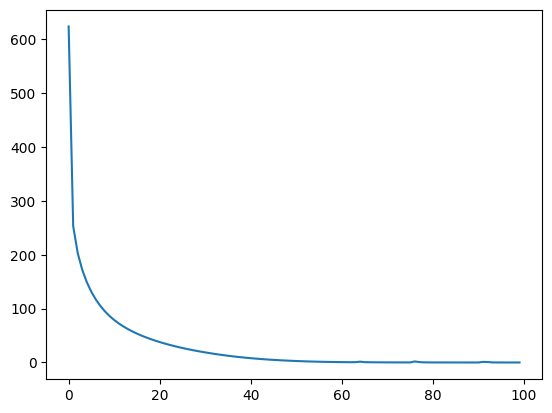

In [12]:
from IPython.display import clear_output

hist = np.array(np.empty([0]))
epochs = 100

for epoch in range(1, epochs+1):
    loss = 0
    for step, (x, y) in enumerate(dataset):
        loss += model.training_step(x, y)
    clear_output(wait=True)
    print(epoch)
    hist = np.append(hist, loss)
    plt.plot(np.arange(0, len(hist)), hist)
    plt.show()

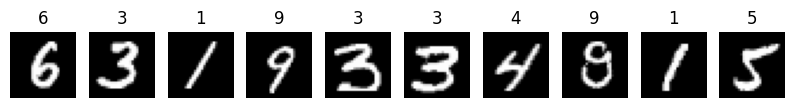

In [13]:
def imshow_and_pred():
    n = 10
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(n):
            img = images[i]
            img_tensor = tf.expand_dims(img, axis=0) # -> [img] <- /batch simulation/
            pred = model.nn(img_tensor)
            pred = tf.squeeze(pred, axis=0) # removal of batch simulation
            pred = pred.numpy()

            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(img, cmap='gist_gray')

            ma = pred.max()
            res = np.where(pred == ma)

            plt.title(res[0][0])
            plt.axis('off')
            ax.get_yaxis().set_visible(False)
    plt.show()
imshow_and_pred()

In [16]:
# prediction

import cv2
my_img = cv2.imread('./images/4.jpg')
img_tensor = tf.expand_dims(my_img, axis=0)
img_tensor = tf.cast(img_tensor, tf.float32) / 255
img_tensor = tf.image.resize(img_tensor, (28, 28), method='area')
img_numpy = img_tensor.numpy()
img_numpy = img_numpy[:,:,:,0]

pred = model.nn(img_numpy)
pred = tf.squeeze(pred, axis=0)
pred = pred.numpy()

ma = pred.max()
res = np.where(pred == ma)
print(res[0][0])

4


In [17]:
model.nn.save('./models/simple_model.h5')

In [18]:
import os
model.nn.load_weights(os.path.join('./models/simple_model.h5'))